# **Practica 2**
#### _Alberto García Doménech - Pablo Daurell Marina_ (Grupo 10)
***

## Parte 1 (Análisis de sentimiento)

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("yelp_labelled.txt", sep='\t', names=['Data', 'Target'])
data = df.to_numpy()[:, 0]
target = df.to_numpy()[:, 1]
target = target.astype('int')

In [3]:
for i in range(10):
    print(data[i], target[i])

Wow... Loved this place. 1
Crust is not good. 0
Not tasty and the texture was just nasty. 0
Stopped by during the late May bank holiday off Rick Steve recommendation and loved it. 1
The selection on the menu was great and so were the prices. 1
Now I am getting angry and I want my damn pho. 0
Honeslty it didn't taste THAT fresh.) 0
The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer. 0
The fries were great too. 1
A great touch. 1


In [4]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.25, random_state=0)

In [5]:
print("Training size: ", train_data.size)
print("Test size: ", test_data.size)

Training size:  750
Test size:  250


In [6]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data.any():
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

## A) Bolsas de palabras

In [7]:
# Diccionario vacío para ir guardando los resultados de cada clasificador
rates = {}

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

### 1. Bolsa de palabras binaria y n-gramas (1,1) 

Creamos una bolsa de palabras con monogramas (solo tenemos en cuenta la probabilidad de una palabra, independientemente del resto) y que tenga en cuenta si una palabra aparece o no:

In [9]:
vectorizer = CountVectorizer(stop_words='english', binary=True, ngram_range = (1,1)) 
train_vector_data = vectorizer.fit_transform(train_data)

feature_names = vectorizer.get_feature_names()
print(len(feature_names))

1510


Ajustamos los datos de test al modelo de bolsa de palabra que acabamos de crear:

In [10]:
test_vector_data = vectorizer.transform(test_data)
print(test_vector_data.shape)

(250, 1510)


Con ayuda de la función ```write_terms```, previamente definida, podemos ver algunos ejemplos de como se han vectorizado los mensajes:

In [11]:
write_terms(feature_names, train_data, train_vector_data, 1)
write_terms(feature_names, train_data, train_vector_data, 10)
write_terms(feature_names, train_data, train_vector_data, 100)

Mensaje 1 : And the chef was generous with his time (even came around twice so we can take pictures with him).
Mensaje 1 vectorizado: ['came' 'chef' 'generous' 'pictures' 'time' 'twice'] 

Mensaje 10 : The cashew cream sauce was bland and the vegetables were undercooked.
Mensaje 10 vectorizado: ['bland' 'cashew' 'cream' 'sauce' 'undercooked' 'vegetables'] 

Mensaje 100 : Now this dish was quite flavourful.
Mensaje 100 vectorizado: ['dish' 'flavourful' 'quite'] 



#### 1.1 Naive Bayes:

- Utilizamos un clasificador Naive Bayes Multinomial (Binarizado), que es útil cuando lo que estamos teniendo en cuenta es la aparición de las palabras, independientemente de su frecuencia.

In [12]:
from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_vector_data, train_target)

mnb_train_predictions = mnb_classifier.predict(train_vector_data)
mnb_test_predictions = mnb_classifier.predict(test_vector_data)

rates.update({'mnb_binary_monogram': {'Train': np.mean(mnb_train_predictions == train_target),
                                'Test' : np.mean(mnb_test_predictions == test_target)}})

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", rates['mnb_binary_monogram']['Train'])
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", rates['mnb_binary_monogram']['Test'])

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9573333333333334
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.728


#### 1.2 Árbol de decisión:

- Probamos distintos valores para el parámetro ```max_depth```para encontrar el que maximice el porcentaje de aciertos en entrnamiento:

In [13]:
from sklearn import tree

train_accuracy = []
test_accuracy = []

max_depths = range(2, 60)
for md in max_depths: 
    # Entrenar y validar
    tree_classifier = tree.DecisionTreeClassifier(criterion="entropy", max_depth=md, min_samples_split=2)
    tree_classifier.fit(train_vector_data, train_target)
                        
    tree_train_predictions = tree_classifier.predict(train_vector_data)
    tree_test_predictions = tree_classifier.predict(test_vector_data)    
    
    train_accuracy.append(np.mean(tree_train_predictions == train_target))
    test_accuracy.append(np.mean(tree_test_predictions == test_target))

In [14]:
import matplotlib.pyplot as plt

# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()   

<Figure size 640x480 with 1 Axes>

- Vemos que con un ```max_depth``` cercano a **39** obtenemos el mejor porcentaje de aciertos en test y un buen porcentaje de aciertos en entrenamiento.   
- Entrenamos un árbol de decisión con este valor:

In [15]:
from sklearn import tree

tree_classifier = tree.DecisionTreeClassifier(max_depth = 39, random_state=0)
tree_classifier.fit(train_vector_data, train_target)

tree_train_predictions = tree_classifier.predict(train_vector_data)
tree_test_predictions = tree_classifier.predict(test_vector_data)

rates.update({'tree_binary_monogram': {'Train': np.mean(tree_train_predictions == train_target),
                                'Test' : np.mean(tree_test_predictions == test_target)}})

print("Árbol, porcentaje de aciertos en entrenamiento:", rates['tree_binary_monogram']['Train'])
print("Árbol, porcentaje de aciertos en test:", rates['tree_binary_monogram']['Test'])

Árbol, porcentaje de aciertos en entrenamiento: 0.896
Árbol, porcentaje de aciertos en test: 0.708


### 2. Bolsa de palabras con TF-IDF y n-gramas (1,1)

Creamos una bolsa de palabras con monogramas (solo tenemos en cuenta la probabilidad de una palabra, independientemente del resto) y que tenga en cuenta la frecuencia de aparición:

In [16]:
vectorizer = CountVectorizer(stop_words='english', binary=False, ngram_range = (1,1))
train_vector_data = vectorizer.fit_transform(train_data)

feature_names = vectorizer.get_feature_names()
print(len(feature_names))

1510


Una vez generada la bolsa de palabras, convertimos los valores de frecuencia a TF-IDF:

In [17]:
tfider = TfidfTransformer()
train_preprocessed = tfider.fit_transform(train_vector_data)
print(train_preprocessed.shape)

(750, 1510)


Ajustamos los datos de test al modelo de bolsa de palabra que acabamos de crear:

In [18]:
test_vector_data = vectorizer.transform(test_data)
test_preprocessed = tfider.transform(test_vector_data)
print(test_preprocessed.shape)

(250, 1510)


#### 2.1 Naive Bayes:

- Utilizamos un clasificador Naive Bayes Gaussiano, ya que estamos teniendo en cuenta un valor continuo como es el TF-IDF.

In [19]:
### GaussianNB no trabaja con matrices dispersas
### Utilizamos la opción partial_fit pasándole fragmentos de la matriz de datos

from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()

chunk_size = 100
num_rows = len(train_target)

for i in range(0, (num_rows//chunk_size)):
    train_chunk = train_preprocessed[i*chunk_size : (i+1)*chunk_size, :].toarray()
    target_chunk = train_target[i*chunk_size : (i+1)*chunk_size]
    gnb_classifier.partial_fit(train_chunk, target_chunk, classes=np.unique(train_target))

In [20]:
### GaussianNB no trabaja con matrices disperas, tampoco a la hora de estimar
### Vamos a estimar por trozos y después agregar los resultados

gnb_train_predictions = np.zeros_like(train_target)
gnb_test_predictions = np.zeros_like(test_target)

for i in range(0, (num_rows//chunk_size)):
    train_chunk = train_preprocessed[i*chunk_size : (i+1)*chunk_size, :].toarray()
    gnb_train_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(train_chunk)
    
num_rows = len(test_target)
for i in range(0, (num_rows//chunk_size)):
    test_chunk = test_preprocessed[i*chunk_size : (i+1)*chunk_size, :].toarray()
    gnb_test_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(test_chunk)
    
    
rates.update({'gnb_tfidf_monogram': {'Train': np.mean(gnb_train_predictions == train_target),
                                'Test' : np.mean(gnb_test_predictions == test_target)}})
    
print("Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento:", rates['gnb_tfidf_monogram']['Train'])
print("Gaussian Naive Bayes, porcentaje de aciertos en test:", rates['gnb_tfidf_monogram']['Test'])

Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9106666666666666
Gaussian Naive Bayes, porcentaje de aciertos en test: 0.612


- Este clasificador nos da unos malos resultados porque los datos no siguen una distribución normal, sino que siguen una distribución asimétrica a la derecha: 

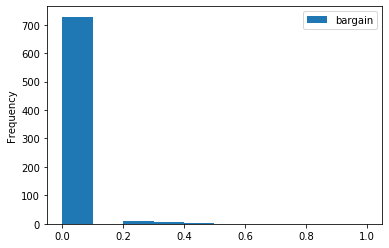

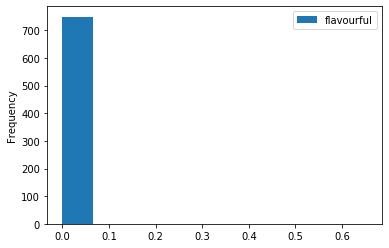

In [21]:
import pandas as pd

term=pd.DataFrame(data= train_preprocessed[:,381].toarray(), columns=[feature_names[100]])
term.plot.hist()

term=pd.DataFrame(data= train_preprocessed[:,500].toarray(), columns=[feature_names[500]])
term.plot.hist()

#### 2.2 Árbol de decisión:

- Probamos distintos valores para el parámetro ```max_depth```para encontrar el que maximice el porcentaje de aciertos en entrnamiento:

In [22]:
from sklearn import tree

train_accuracy = []
test_accuracy = []

max_depths = range(2, 70)
for md in max_depths: 
    # Entrenar y validar
    tree_classifier = tree.DecisionTreeClassifier(criterion="entropy", max_depth=md, min_samples_split=2)
    tree_classifier.fit(train_preprocessed, train_target)
                        
    tree_train_predictions = tree_classifier.predict(train_preprocessed)
    tree_test_predictions = tree_classifier.predict(test_preprocessed)    
    
    train_accuracy.append(np.mean(tree_train_predictions == train_target))
    test_accuracy.append(np.mean(tree_test_predictions == test_target))

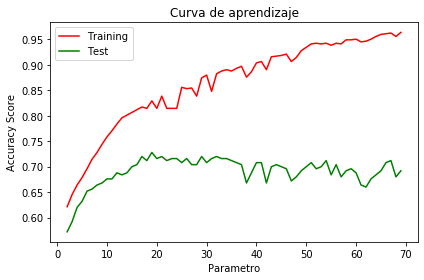

In [23]:
import matplotlib.pyplot as plt

# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()   

- Vemos que con un ```max_depth``` cercano a **17** obtenemos el mejor porcentaje de aciertos en test y un buen porcentaje de aciertos en entrenamiento.   
- Entrenamos un árbol de decisión con este valor:

In [24]:
from sklearn import tree

tree_classifier = tree.DecisionTreeClassifier(max_depth = 17, random_state=0)
tree_classifier.fit(train_preprocessed, train_target)

tree_train_predictions = tree_classifier.predict(train_preprocessed)
tree_test_predictions = tree_classifier.predict(test_preprocessed)

rates.update({'tree_tfidf_monogram': {'Train': np.mean(tree_train_predictions == train_target),
                                'Test' : np.mean(tree_test_predictions == test_target)}})

print("Árbol, porcentaje de aciertos en entrenamiento:", rates['tree_tfidf_monogram']['Train'])
print("Árbol, porcentaje de aciertos en test:", rates['tree_tfidf_monogram']['Test'])

Árbol, porcentaje de aciertos en entrenamiento: 0.82
Árbol, porcentaje de aciertos en test: 0.72


### 3. Bolsa de palabras binarias y n-gramas (1,2)

Creamos una bolsa de palabras con bigramas (tenemos en cuenta la probabilidad de una palabra en función de la palabra anterior) y que tenga en cuenta si una palabra aparece o no:

In [25]:
vectorizer = CountVectorizer(stop_words='english', binary=True, ngram_range = (1,2)) 
train_vector_data = vectorizer.fit_transform(train_data)

feature_names = vectorizer.get_feature_names()
print(len(feature_names))

4347


Ajustamos los datos de test al modelo de bolsa de palabra que acabamos de crear:

In [26]:
test_vector_data = vectorizer.transform(test_data)
print(test_vector_data.shape)

(250, 4347)


Con ayuda de la función ```write_terms```, podemos ver algunos ejemplos de como se han vectorizado los mensajes.  
> A diferencia de los dos casos anteriores, aquí usamos bigramas. Vemos como eso hace que aumente el número de términos (antes 1510, ahora 4347) y podemos ver en los mensajes vectorizados que ahora algunos terminos constan de dos palabras:

In [27]:
write_terms(feature_names, train_data, train_vector_data, 1)
write_terms(feature_names, train_data, train_vector_data, 10)
write_terms(feature_names, train_data, train_vector_data, 100)

Mensaje 1 : And the chef was generous with his time (even came around twice so we can take pictures with him).
Mensaje 1 vectorizado: ['came' 'came twice' 'chef' 'chef generous' 'generous' 'generous time'
 'pictures' 'time' 'time came' 'twice' 'twice pictures'] 

Mensaje 10 : The cashew cream sauce was bland and the vegetables were undercooked.
Mensaje 10 vectorizado: ['bland' 'bland vegetables' 'cashew' 'cashew cream' 'cream' 'cream sauce'
 'sauce' 'sauce bland' 'undercooked' 'vegetables' 'vegetables undercooked'] 

Mensaje 100 : Now this dish was quite flavourful.
Mensaje 100 vectorizado: ['dish' 'dish quite' 'flavourful' 'quite' 'quite flavourful'] 



#### 3.1 Naive Bayes:

- Utilizamos un clasificador Naive Bayes Multinomial (Binarizado), que es útil cuando lo que estamos teniendo en cuenta es la aparición de las palabras, independientemente de su frecuencia.

In [28]:
from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_vector_data, train_target)

mnb_train_predictions = mnb_classifier.predict(train_vector_data)
mnb_test_predictions = mnb_classifier.predict(test_vector_data)

rates.update({'mnb_binary_bigram': {'Train': np.mean(mnb_train_predictions == train_target),
                                'Test' : np.mean(mnb_test_predictions == test_target)}})

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:",rates['mnb_binary_bigram']['Train'])
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", rates['mnb_binary_bigram']['Test'])

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9786666666666667
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.732


#### 3.2 Árbol de decisión:

- Probamos distintos valores para el parámetro ```max_depth```para encontrar el que maximice el porcentaje de aciertos en entrnamiento:

In [29]:
from sklearn import tree

train_accuracy = []
test_accuracy = []

max_depths = range(2, 60)
for md in max_depths: 
    # Entrenar y validar
    tree_classifier = tree.DecisionTreeClassifier(criterion="entropy", max_depth=md, min_samples_split=2)
    tree_classifier.fit(train_vector_data, train_target)
                        
    tree_train_predictions = tree_classifier.predict(train_vector_data)
    tree_test_predictions = tree_classifier.predict(test_vector_data)    
    
    train_accuracy.append(np.mean(tree_train_predictions == train_target))
    test_accuracy.append(np.mean(tree_test_predictions == test_target))

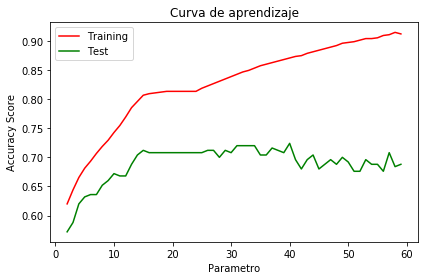

In [30]:
import matplotlib.pyplot as plt

# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()   

- Vemos que con un ```max_depth``` cercano a **38** obtenemos el mejor porcentaje de aciertos en test y un buen porcentaje de aciertos en entrenamiento.   
- Entrenamos un árbol de decisión con este valor:

In [31]:
from sklearn import tree

tree_classifier = tree.DecisionTreeClassifier(max_depth = 38, random_state=0)
tree_classifier.fit(train_vector_data, train_target)

tree_train_predictions = tree_classifier.predict(train_vector_data)
tree_test_predictions = tree_classifier.predict(test_vector_data)

rates.update({'tree_binary_bigram': {'Train': np.mean(tree_train_predictions == train_target),
                                'Test' : np.mean(tree_test_predictions == test_target)}})

print("Árbol, porcentaje de aciertos en entrenamiento:", rates['tree_binary_bigram']['Train'])
print("Árbol, porcentaje de aciertos en test:", rates['tree_binary_bigram']['Test'])

Árbol, porcentaje de aciertos en entrenamiento: 0.8946666666666667
Árbol, porcentaje de aciertos en test: 0.704


### 4. Bolsa de palabras con TF-IDF y n-gramas (1,2)

Creamos una bolsa de palabras con bigramas (tenemos en cuenta la probabilidad de una palabra en función de la palabra anterior) y que tenga en cuenta la frecuencia de aparición:

In [32]:
vectorizer = CountVectorizer(stop_words='english', binary=False, ngram_range = (1,2))
train_vector_data = vectorizer.fit_transform(train_data)

feature_names = vectorizer.get_feature_names()
print(len(feature_names))

4347


Una vez generada la bolsa de palabras, convertimos los valores de frecuencia a TF-IDF:

In [33]:
tfider = TfidfTransformer()
train_preprocessed = tfider.fit_transform(train_vector_data)
print(train_preprocessed.shape)

(750, 4347)


Ajustamos los datos de test al modelo de bolsa de palabra que acabamos de crear:

In [34]:
test_vector_data = vectorizer.transform(test_data)
test_preprocessed = tfider.transform(test_vector_data)
print(test_preprocessed.shape)

(250, 4347)


#### 4.1 Naive Bayes:

- Utilizamos un clasificador Naive Bayes Gaussiano, ya que estamos teniendo en cuenta un valor continuo como es el TF-IDF.

In [35]:
### GaussianNB no trabaja con matrices dispersas
### Utilizamos la opción partial_fit pasándole fragmentos de la matriz de datos

from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()

chunk_size = 100
num_rows = len(train_target)

for i in range(0, (num_rows//chunk_size)):
    train_chunk = train_preprocessed[i*chunk_size : (i+1)*chunk_size, :].toarray()
    target_chunk = train_target[i*chunk_size : (i+1)*chunk_size]
    gnb_classifier.partial_fit(train_chunk, target_chunk, classes=np.unique(train_target))

In [36]:
### GaussianNB no trabaja con matrices disperas, tampoco a la hora de estimar
### Vamos a estimar por trozos y después agregar los resultados

gnb_train_predictions = np.zeros_like(train_target)
gnb_test_predictions = np.zeros_like(test_target)

for i in range(0, (num_rows//chunk_size)):
    train_chunk = train_preprocessed[i*chunk_size : (i+1)*chunk_size, :].toarray()
    gnb_train_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(train_chunk)
    
num_rows = len(test_target)
for i in range(0, (num_rows//chunk_size)):
    test_chunk = test_preprocessed[i*chunk_size : (i+1)*chunk_size, :].toarray()
    gnb_test_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(test_chunk)
    
rates.update({'gnb_tfidf_bigram': {'Train': np.mean(gnb_train_predictions == train_target),
                                'Test' : np.mean(gnb_test_predictions == test_target)}})    

print("Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento:", rates['gnb_tfidf_bigram']['Train'])
print("Gaussian Naive Bayes, porcentaje de aciertos en test:", rates['gnb_tfidf_bigram']['Test'])

Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9346666666666666
Gaussian Naive Bayes, porcentaje de aciertos en test: 0.616


- Este clasificador nos da unos malos resultados porque los datos no siguen una distribución normal, sino que siguen una distribución asimétrica a la derecha: 

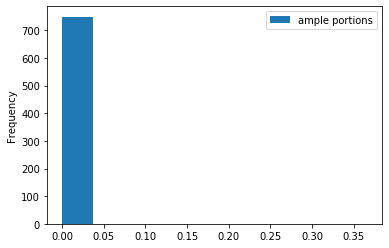

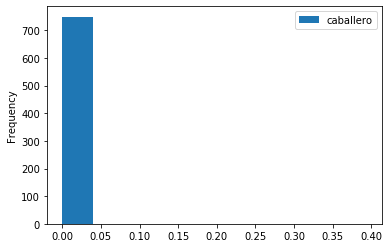

In [37]:
import pandas as pd

term=pd.DataFrame(data= train_preprocessed[:,381].toarray(), columns=[feature_names[100]])
term.plot.hist()

term=pd.DataFrame(data= train_preprocessed[:,500].toarray(), columns=[feature_names[500]])
term.plot.hist()

#### 4.2 Árbol de decisión:

- Probamos distintos valores para el parámetro ```max_depth```para encontrar el que maximice el porcentaje de aciertos en entrnamiento:

In [38]:
from sklearn import tree

train_accuracy = []
test_accuracy = []

max_depths = range(2, 70)
for md in max_depths: 
    # Entrenar y validar
    tree_classifier = tree.DecisionTreeClassifier(criterion="entropy", max_depth=md, min_samples_split=2)
    tree_classifier.fit(train_preprocessed, train_target)
                        
    tree_train_predictions = tree_classifier.predict(train_preprocessed)
    tree_test_predictions = tree_classifier.predict(test_preprocessed)    
    
    train_accuracy.append(np.mean(tree_train_predictions == train_target))
    test_accuracy.append(np.mean(tree_test_predictions == test_target))

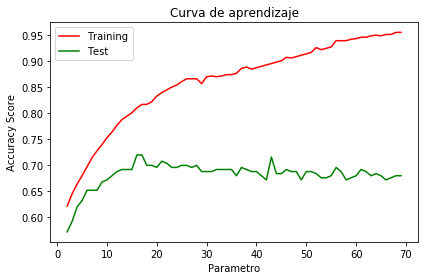

In [39]:
import matplotlib.pyplot as plt

# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()   

- Vemos que con un ```max_depth``` cercano a **17** obtenemos el mejor porcentaje de aciertos en test y un buen porcentaje de aciertos en entrenamiento.   
- Entrenamos un árbol de decisión con este valor:

In [40]:
from sklearn import tree

tree_classifier = tree.DecisionTreeClassifier(max_depth = 17, random_state=0)
tree_classifier.fit(train_preprocessed, train_target)

tree_train_predictions = tree_classifier.predict(train_preprocessed)
tree_test_predictions = tree_classifier.predict(test_preprocessed)

rates.update({'tree_tfidf_bigram': {'Train': np.mean(tree_train_predictions == train_target),
                                'Test' : np.mean(tree_test_predictions == test_target)}})

print("Árbol, porcentaje de aciertos en entrenamiento:", rates['tree_tfidf_bigram']['Train'])
print("Árbol, porcentaje de aciertos en test:", rates['tree_tfidf_bigram']['Test'])

Árbol, porcentaje de aciertos en entrenamiento: 0.82
Árbol, porcentaje de aciertos en test: 0.72


### Comparación:

- Comprobamos los porcentajes de aciertos para cada conficuración elegida:

In [41]:
i = 0
for a, b in rates.items():
    print(a, b)
    if(i%2 != 0):
        print('----------------------')
    i = i + 1

mnb_binary_monogram {'Train': 0.9573333333333334, 'Test': 0.728}
tree_binary_monogram {'Train': 0.896, 'Test': 0.708}
----------------------
gnb_tfidf_monogram {'Train': 0.9106666666666666, 'Test': 0.612}
tree_tfidf_monogram {'Train': 0.82, 'Test': 0.72}
----------------------
mnb_binary_bigram {'Train': 0.9786666666666667, 'Test': 0.732}
tree_binary_bigram {'Train': 0.8946666666666667, 'Test': 0.704}
----------------------
gnb_tfidf_bigram {'Train': 0.9346666666666666, 'Test': 0.616}
tree_tfidf_bigram {'Train': 0.82, 'Test': 0.72}
----------------------


 #### ¿Hay un clasificador que sea superior al otro? ¿por qué crees que sucede?##


Podemos observar que los diferentes resultados de test no varian demasiado entre clasificadores, aunque obtenemos los mejores resultados con el clasificador naive bayes (73,2% y 72,8%)

#### Para cada clasificador, ¿tiene un efecto positivo el añadir “complejidad” a la vectorización? Es decir, añadir bigramas y añadir tf-idf. ¿Por qué crees que sucede este efecto positivo o la falta del mismo? ###

Para el clasificador Naive Bayes hay una ligera mejoría (+0,4%) si aumentamos la complejidad de los n-gramas pero vemos un descenso en los resultados de test si cambiamos la frecuencia binaria por la tfdif (-11,6%), esto se debe a como funciona el clasificador naive bayes ya que (TERMINAR)

En cambio los arboles de decision empeoran en resultados de test si añadimos bigrama (usando frecuencia binaria desciende un 0,4% y con frecuencia tfidf no varia en resultados), sin embargo vemos que añadiendo tfidf conseguimos los mismos resultados, que a la vez son los mejores obtenidos por el arbol, dando igual la complejidad de los n-gramas. Este efecto positivo se debe a a que los arboles de decision pueden elegir variables con mayor poder discriminante si escogen palabras con una frecuencia no binaria.

Podemos concluir que podemos mejorar los resultados si aumentamos la complejidad de los n-gramas en bayes y la de la frecuencia en los arboles

#### Selecciona el mejor árbol de decisión y obtén las 25 variables con más poder discriminante: ¿Predominan más las palabras de uno u otro sentimiento? ¿por qué? ¿hay ruido? ###

Seleccionamos cualquiera de los dos arboles de decision que tengan en cuenta la frecuencia TF/IDF, en este caso cogemos el arbol de decision con monogramas(ya que queremos analizar las 25 variables con mayor poder discriminante y al ser monogramas estas seran una palabra en vez de poder ser una o dos)

[Text(259.2375, 211.4, 'X[567] <= 0.072\ngini = 0.5\nsamples = 750\nvalue = [383, 367]'),
 Text(249.93750000000003, 199.32, 'X[557] <= 0.158\ngini = 0.496\nsamples = 701\nvalue = [383, 318]'),
 Text(206.925, 187.24, 'X[39] <= 0.113\ngini = 0.488\nsamples = 635\nvalue = [367, 268]'),
 Text(188.32500000000002, 175.16, 'X[336] <= 0.118\ngini = 0.483\nsamples = 617\nvalue = [366, 251]'),
 Text(179.025, 163.07999999999998, 'X[874] <= 0.222\ngini = 0.478\nsamples = 604\nvalue = [366, 238]'),
 Text(153.45000000000002, 151.0, 'X[520] <= 0.279\ngini = 0.471\nsamples = 587\nvalue = [364, 223]'),
 Text(144.15, 138.92000000000002, 'X[121] <= 0.26\ngini = 0.465\nsamples = 576\nvalue = [364, 212]'),
 Text(120.9, 126.84, 'X[774] <= 0.146\ngini = 0.457\nsamples = 558\nvalue = [361, 197]'),
 Text(111.60000000000001, 114.75999999999999, 'X[470] <= 0.112\ngini = 0.451\nsamples = 550\nvalue = [361, 189]'),
 Text(102.30000000000001, 102.67999999999999, 'X[773] <= 0.287\ngini = 0.445\nsamples = 542\nvalue =

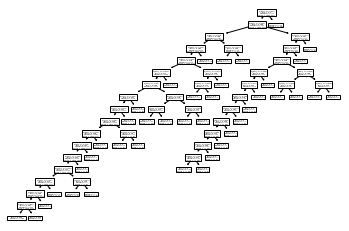

In [42]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

vectorizer = CountVectorizer(stop_words='english', binary=False, ngram_range = (1,1))
train_vector_data = vectorizer.fit_transform(train_data)

feature_names = vectorizer.get_feature_names()
tfider = TfidfTransformer()
train_preprocessed = tfider.fit_transform(train_vector_data)
test_vector_data = vectorizer.transform(test_data)
test_preprocessed = tfider.transform(test_vector_data)

tree_classifier = tree.DecisionTreeClassifier(max_depth = 17, random_state=0)
tree_classifier.fit(train_preprocessed, train_target)

plot_tree(tree_classifier, max_depth = 17)

In [43]:
def print_top25_features_in_trees(vectorizer, clf):
    """Prints features with the highest coefficient values"""
    feature_names = vectorizer.get_feature_names()
    
    top25 = np.argsort(clf.feature_importances_)[-25:]
    reversed_top = top25[::-1]
    print("Top 25 features in the tree\n")
    print("%s" % ( " ".join(feature_names[j] for j in reversed_top)))

print_top25_features_in_trees(vectorizer,tree_classifier)

Top 25 features in the tree

great good amazing best delicious friendly nice fantastic loved awesome love perfect happy restaurant excellent enjoyed definitely way don quickly pale recent beans kabuki par


Claramente predeominan las palabras de sentimiento positivo, esto se puede deber a que la presencia de cualquiera de las palabras anteriores solo estarán en mensajes con sentimiento positivo. No hay ruido pero si hay palabras que podrian ser de cualquiera de los dos sentimientos como "par" y "restaurant".


#### Selecciona el mejor clasificador naive bayes y obtén las 25 variables con más presencia en cada clase:¿Tienen sentido las palabras seleccionadas? ¿hay ruido (palabras sin sentimiento o de sentimiento opuesto al esperado)? ¿por qué crees que suceden estos fenómenos?

El mejor clasificador naive bayes que hemos obtenido es el que utiliza la frecuencia binaria y bigramas con un una precision en test de un 73,2%

In [44]:
vectorizer = CountVectorizer(stop_words='english', binary=True, ngram_range = (1,2)) 
train_vector_data = vectorizer.fit_transform(train_data)

feature_names = vectorizer.get_feature_names()
test_vector_data = vectorizer.transform(test_data)

from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_vector_data, train_target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [45]:
def print_top25_features_per_class_in_NB(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    print("Top 25 features per class\n")
    for i, class_label in enumerate(class_labels):
        top25 = np.argsort(clf.feature_log_prob_[i])[-25:]
        reversed_top = top25[::-1]
        print("%s:   %s" % (class_label,
              " ".join(feature_names[j] for j in reversed_top)),'\n')
print_top25_features_per_class_in_NB(vectorizer,mnb_classifier,class_labels = [0,1])  

Top 25 features per class

0:   food place service like don good won ve time bad disappointed really worst just wasn minutes did got going eat think terrible came probably times 

1:   good great food place service really best amazing just nice friendly time delicious love menu staff awesome restaurant like vegas pizza definitely experience loved perfect 



Podemos ver que hay varias palabras que las dos clases comparten(food, time, place, service) que aunque no tengan sentimiento implicito sirven para describir un sentimiento con un adjetivo adjunto y son palabras muy comunes para valorar un restaurante(la comida, el servicio,el tiempo de espera o la decoracion del sitio).
En la clase 0 (sentimiento negativo) podemos ver la palabra good que en principio denota un sentimiento positivo pero como tambien hay presencia de negativas (como don,wasn) puede que simplemente este presente junto a una negación. Además hay algo de presencia de ruido(aparte de las varibles repetidas en las dos clases) como la palabra think que simplemente sirve para expresar una opinión.
En la clase 1 (sentimiento positivo) no encontramos ninguna palabra que en principio exprese sentimiento negativo pero si encontramos algo de ruido como experience o menu que no denota ningún sentimiento, pero como la gran mayoría son adjetivos positivos es bastante seguro asumir que vienen acompañados de estos y denotan un senitmiento positivo. Además tenemos la palabra vegas que podemos asumir que es el nombre de un plato que ha gustado mucho como pizza.

#### Conclusiones

In [75]:
# mejor clasificador naive bayes(frecuencia binaria y bigramas)
vectorizer = CountVectorizer(stop_words='english', binary=True, ngram_range = (1,2)) 
train_vector_data = vectorizer.fit_transform(train_data)

feature_names = vectorizer.get_feature_names()
test_vector_data = vectorizer.transform(test_data)

from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_vector_data, train_target)

mnb_train_predictions = mnb_classifier.predict(train_vector_data)
mnb_test_predictions = mnb_classifier.predict(test_vector_data)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true = test_target, y_pred = mnb_test_predictions, target_names = ["Sentimiento negativo", "Sentimiento positivo"]))
false_pos,false_neg = 0,0
for i in range(len(mnb_test_predictions)):
    if(mnb_test_predictions[i] == 1 and test_target[i] == 0):
        false_pos += 1
    elif(mnb_test_predictions[i] == 0 and test_target[i] == 1):
        false_neg +=1

In [82]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true = test_target, y_pred = mnb_test_predictions, target_names = ["Sentimiento negativo", "Sentimiento positivo"]))
false_pos,false_neg = 0,0
for i in range(len(mnb_test_predictions)):
    if(mnb_test_predictions[i] == 1 and test_target[i] == 0):
        false_pos += 1
    elif(mnb_test_predictions[i] == 0 and test_target[i] == 1):
        false_neg +=1
print("Falsos positivos:" ,false_pos, "Falsos negativos:" , false_neg)

                      precision    recall  f1-score   support

Sentimiento negativo       0.73      0.68      0.70       117
Sentimiento positivo       0.74      0.77      0.75       133

            accuracy                           0.73       250
           macro avg       0.73      0.73      0.73       250
        weighted avg       0.73      0.73      0.73       250

Falsos positivos: 37 Falsos negativos: 30
